In [1]:
import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers, get_layer_out_shape
from pref_viewing.utils import plot_imgs
from alignment.utils import get_usual_transform
from parallel.parallel_funcs import print_wise
from torchvision.models.feature_extraction import (
    create_feature_extractor,
    get_graph_node_names,
)
from torchvision.transforms import ToPILImage
from PIL import Image
from torchvision import models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
from pref_viewing.utils import get_extreme_k
from datetime import datetime
import torch
from experiments.images_sampling import save_imgs_PCs, save_imgs_CCs
from experiments.utils import project_onto_PCs, project_onto_CCs, map_on_savenames,get_k_imgs
import pandas as pd

[Tiziano-Causin.local:68643] shmem: mmap: an error occurred while determining whether or not /var/folders/nw/yf48zdjj1m5012281wx_pzhc0000gn/T//ompi.Tiziano-Causin.501/jf.0/2695299072/sm_segment.Tiziano-Causin.501.a0a70000.0 could be created.


In [2]:
transform = get_usual_transform()
dataset = datasets.ImageFolder(f"{paths["data_path"]}/imagenet/val", transform=transform)

transform_to_show = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
dataset_to_show = datasets.ImageFolder(f"{paths["data_path"]}/imagenet/val", transform=transform_to_show)

In [3]:
model_name1, model_name2 = "alexnet", "resnet50"
target_layer1, target_layer2 = "features.0", "conv1"
pooling = "maxpool"
d1, d2 = project_onto_CCs(model_name1, model_name2, target_layer1, target_layer2, pooling, 50, paths)

In [4]:
save_imgs_CCs(d1, model_name1, model_name2, target_layer1, target_layer2, dataset_to_show, pooling, 5, 5, paths)

/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+ResNet50_features0+conv1_maxpool/net_AlexNet+ResNet50_layer_features0+conv1_pc0_top_0_0.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+ResNet50_features0+conv1_maxpool/net_AlexNet+ResNet50_layer_features0+conv1_pc0_top_1_1.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+ResNet50_features0+conv1_maxpool/net_AlexNet+ResNet50_layer_features0+conv1_pc0_top_2_2.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+ResNet50_features0+conv1_maxpool/net_AlexNet+ResNet50_layer_features0+conv1_pc0_top_3_3.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+ResNet50_features0+conv1_maxpool/net_AlexNet+ResNet50_layer_features0+conv1_pc0_top_4_4.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+ResNet50_features0+conv1_maxpool/net_AlexNet+ResNet50_layer_features0+conv1_pc0_bottom_0_5.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+ResNet50_features0+conv1_maxpool/net_AlexNet+ResNet50_layer_features0+conv1_pc0_bottom_1_6.png


In [3]:
model_name1 = "alexnet"
target_layer1 = "features.4"
pooling = "maxpool"
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
d = joblib.load(feats_path1)
dat = project_onto_PCs(model_name1, target_layer1, pooling, paths)

In [7]:
num_dim = 10
k = 10
save_imgs_PCs(dat, model_name1, target_layer1, dataset_to_show,pooling, num_dim, k, paths)

NameError: name 'dat' is not defined

In [93]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "alexnet"
#target_layer = "encoder.layers.encoder_layer_0.add_1"
target_layer = "features.4"
model_cls = getattr(models, model_name)
model = model_cls(pretrained=True).to(device).eval()
feature_extractor = create_feature_extractor(
    model, return_nodes=[target_layer]
).to(device)
n_dims = 10

/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/ponce_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [94]:
extreme_n_imgs = 100
top_n_PCs = 10
top_save_path = f"{paths["results_path"]}/{model_name}_{target_layer}_top_{extreme_n_imgs}_imgs_{top_n_PCs}_PCs.csv"
bottom_save_path = f"{paths["results_path"]}/{model_name}_{target_layer}_bottom_{extreme_n_imgs}_imgs_{top_n_PCs}_PCs.csv"
top_dims = np.loadtxt(top_save_path, delimiter=',', dtype=int)
bottom_dims = np.loadtxt(bottom_save_path, delimiter=',', dtype=int)

In [88]:
d = 1
k = 10
t = []
topk_imgs_all_feats = [dataset_to_show[i][0] for i in top_dims[d, :k]]
botk_imgs_all_feats = [dataset_to_show[i][0] for i in bottom_dims[d, :k]]

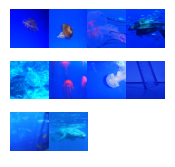

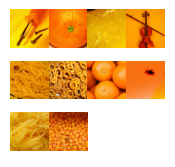

In [89]:
atopk_imgs_all_feats = [dataset_to_show[i][0].permute(1,2,0) for i in top_dims[d, :k]]
abotk_imgs_all_feats = [dataset_to_show[i][0].permute(1,2,0) for i in bottom_dims[d, :k]]

najdnouf = plot_imgs(atopk_imgs_all_feats)
nevjnrio = plot_imgs(abotk_imgs_all_feats)

In [95]:
def give_top_imgs(dataset_to_show, d, top_dims, bottom_dims, k):
    topk_imgs_all_feats = [dataset_to_show[i][0] for i in top_dims[d, :k]]
    botk_imgs_all_feats = [dataset_to_show[i][0] for i in bottom_dims[d, :k]]
    return topk_imgs_all_feats, botk_imgs_all_feats

extremes = ["top", "bottom"]
m_n = "AlexNet"
#m_n = "vit_b_16"

l_n = "features4"
#l_n = "encoder.layers.encoder_layer_0.add_1"
root_dir = f"/Volumes/PonceLab/Stimuli/2025_diverseset/{m_n}_{l_n}"
counter = 0
to_pil = ToPILImage()
for d in range(10):
    topk_imgs_all_feats, botk_imgs_all_feats = give_top_imgs(dataset_to_show, d, top_dims, bottom_dims, k)
    for extreme in extremes:
        for idx in range(len(pool_topk_imgs)):
            path2save = f"{root_dir}/net_{m_n}_layer_{l_n}_pc{d}_{extreme}_{idx}_{counter}.png"
            print(path2save)
            counter +=1
            if extreme == "top":
                to_pil(topk_imgs_all_feats[idx]).save(path2save)
            else:
                to_pil(botk_imgs_all_feats[idx]).save(path2save)

/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_0_0.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_1_1.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_2_2.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_3_3.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_4_4.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_5_5.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_6_6.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_7_7.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_AlexNet_layer_features4_pc0_top_8_8.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet_features4/net_

In [100]:
model_name1 = "alexnet"
model_name2 = "vit_b_16"
target_layer1 = "features.4"
target_layer2 = "encoder.layers.encoder_layer_0.add_1"
pooling = "PC_pool"
n_components_cca = 100
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
feats1 = joblib.load(feats_path1)
feats_path2 = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_features.pkl"
feats2 = joblib.load(feats_path2)
cca_path = f"{paths["results_path"]}/cca_{model_name1}_vs_{model_name2}_{pooling}/cca_{model_name1}_vs_{model_name2}_{n_components_cca}_components_pca_{target_layer1}_vs_{target_layer2}.pkl"
weights_dict = joblib.load(cca_path)

In [101]:
d1 = feats1 @ weights_dict["W1"]
d2 = feats2 @ weights_dict["W2"]

In [108]:

topk_imgs, bottomk_imgs, topk_indices, bottomk_indices = get_k_imgs(d1, dataset_to_show, k, 2)
extremes = ["top", "bottom"]
m_n = "AlexNet"
#m_n = "vit_b_16"

l_n = "features4"
#l_n = "encoder.layers.encoder_layer_0.add_1"
root_dir = f"/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1"
counter = 0
to_pil = ToPILImage()
for d in range(10):
    topk_imgs_all_feats, botk_imgs_all_feats, _, _ = get_k_imgs(d1, dataset_to_show, k, d)
    for extreme in extremes:
        for idx in range(len(pool_topk_imgs)):
            path2save = f"{root_dir}/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc{d}_{extreme}_{idx}_{counter}.png"
            print(path2save)
            counter +=1
            if extreme == "top":
                to_pil(topk_imgs_all_feats[idx]).save(path2save)
            else:
                to_pil(botk_imgs_all_feats[idx]).save(path2save)

[26517  5396 42203  1713  1714 38476  5359  5388  5385  5368]
[45229 45231 25332 36359 38507 40760 43934  5105 42948 40777]
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc0_top_0_0.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc0_top_1_1.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc0_top_2_2.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc0_top_3_3.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1/net_AlexNe

In [40]:
d = 0
model_name = "vit_b_16"
target_layer = "encoder.layers.encoder_layer_0.add_1"
pooling = "maxpool"
feats_path_pool = f"{paths["results_path"]}/imagenet_val_{model_name}_{target_layer}_{pooling}_features.pkl"
feats_pool = joblib.load(feats_path_pool)
PCs_path_pool = f"{paths["results_path"]}/imagenet_val_{model_name}_{target_layer}_{pooling}_pca_model_1000_PCs.pkl"
PCs_pool = joblib.load(PCs_path_pool)
dim_redu_pool = feats_pool@PCs_pool.components_.T

In [41]:
top_maxpool = []
bot_maxpool = []
pool_topk_imgs, pool_bottomk_imgs, top_k_idx, bot_k_idx = get_k_imgs(dim_redu_pool, dataset_to_show, k, d)
#top_maxpool.append(pool_topk_imgs)
#bot_maxpool.append(pool_bottomk_imgs)

[45857 17041 34635 27989 34283 36174 45918 43934 21391 21211]


[45857 17041 34635 27989 34283 36174 45918 43934 21391 21211]


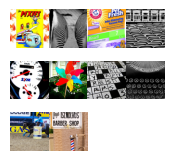

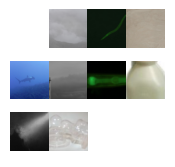

In [42]:
apool_topk_imgs, apool_bottomk_imgs, atop_k_idx, abot_k_idx = get_kk_imgs(dim_redu_pool, dataset_to_show, k, d)
najdnouf = plot_imgs(apool_topk_imgs)
nevjnrio = plot_imgs(apool_bottomk_imgs)

In [43]:
extremes = ["top", "bottom"]
#m_n = "AlexNet"
m_n = "vit_b_16"
#l_n = "features4"
l_n = "encoder.layers.encoder_layer_0.add_1"
root_dir = f"/Volumes/PonceLab/Stimuli/2025_diverseset/{m_n}_{l_n}_maxpool"
counter = 0
d = 1
to_pil = ToPILImage()
for extreme in extremes:
    for idx in range(len(pool_topk_imgs)):
        path2save = f"{root_dir}/net_{m_n}_layer_{l_n}_pc{d}_{extreme}_{idx}_{counter}_maxpool.png"
        print(path2save)
        #real_path = fr"{real_root_dir}\net_{m_n}_layer_{l_n}_pc{d}_{extreme}_{idx}_{counter}_maxpool.png"
        counter +=1
        if extreme == "top":
            to_pil(pool_topk_imgs[idx]).save(path2save)
        else:
            to_pil(pool_bottomk_imgs[idx]).save(path2save)

/Volumes/PonceLab/Stimuli/2025_diverseset/vit_b_16_encoder.layers.encoder_layer_0.add_1_maxpool/net_vit_b_16_layer_encoder.layers.encoder_layer_0.add_1_pc1_top_0_0_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/vit_b_16_encoder.layers.encoder_layer_0.add_1_maxpool/net_vit_b_16_layer_encoder.layers.encoder_layer_0.add_1_pc1_top_1_1_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/vit_b_16_encoder.layers.encoder_layer_0.add_1_maxpool/net_vit_b_16_layer_encoder.layers.encoder_layer_0.add_1_pc1_top_2_2_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/vit_b_16_encoder.layers.encoder_layer_0.add_1_maxpool/net_vit_b_16_layer_encoder.layers.encoder_layer_0.add_1_pc1_top_3_3_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/vit_b_16_encoder.layers.encoder_layer_0.add_1_maxpool/net_vit_b_16_layer_encoder.layers.encoder_layer_0.add_1_pc1_top_4_4_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/vit_b_16_encoder.layers.encoder_layer_0.add_1_maxpool/net_vit_b_16_layer_encod

In [40]:
to_pil = ToPILImage()
to_pil(pool_topk_imgs[2]).save(path2save)

[34283 28759 27335 15502 36174 27301 25315 37339 37309 17029]


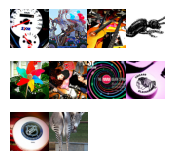

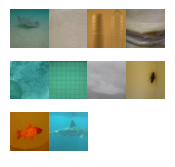

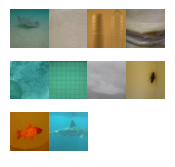

In [70]:
t, b, c, e =  get_kk_imgs(dim_redu_pool, dataset_to_show, k, 0)
plot_imgs(t)
plot_imgs(b)

In [44]:
model_name1 = "alexnet"
model_name2 = "vit_b_16"
mod1_layers = get_relevant_output_layers(model_name1)
mod2_layers = get_relevant_output_layers(model_name2)
target_layer1 = "features.4"
target_layer2 = "encoder.layers.encoder_layer_0.add_1"
pooling = "maxpool"
n_components_cca = 50
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
feats1 = joblib.load(feats_path1)
PCs1_path = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_pca_model_1000_PCs.pkl"
PCs1 = joblib.load(PCs1_path)
feats_path2 = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_features.pkl"
feats2 = joblib.load(feats_path2)
PCs2_path = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_pca_model_1000_PCs.pkl"
PCs2 = joblib.load(PCs2_path)
cca_path = f"{paths["results_path"]}/cca_{model_name1}_vs_{model_name2}_{pooling}/cca_{model_name1}_vs_{model_name2}_{n_components_cca}_components_{target_layer1}_vs_{target_layer2}.pkl"

weights_dict = joblib.load(cca_path)

In [46]:
d1 = feats1 @ weights_dict["W1"]
d2 = feats2 @ weights_dict["W2"]

In [51]:
d = 1
mod1_topk_imgs_cca, mod1_bottomk_imgs_cca, top_idx, bot_idx = get_k_imgs(d1, dataset_to_show, k, d)


[33936 36187 34836 42964   916 45100 20985 26517 26509 36874]


In [52]:
root_dir = "/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_maxpool"
extremes = ["top", "bottom"]
counter = 20
to_pil = ToPILImage()
for extreme in extremes:
    for idx in range(len(pool_topk_imgs)):
        path2save = f"{root_dir}/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc{d}_{extreme}_{idx}_{counter}_maxpool.png"
        print(path2save)
        counter +=1
        if extreme == "top":
            to_pil(mod1_topk_imgs_cca[idx]).save(path2save)
        else:
            to_pil(mod1_bottomk_imgs_cca[idx]).save(path2save)

/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_maxpool/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc1_top_0_20_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_maxpool/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc1_top_1_21_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_maxpool/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc1_top_2_22_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_maxpool/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_pc1_top_3_23_maxpool.png
/Volumes/PonceLab/Stimuli/2025_diverseset/AlexNet+vit_b_16_features4+encoder.layers.encoder_layer_0.add_1_maxpool/net_AlexNet+vit_b_16_features4+encoder.layers.encoder_laye